# Handwritten Devnagari Character classification
### Author: Sanjay Jaras
### Bellevue University

## Import Libraries

In [1]:
#!pip install git+https://github.com/tensorflow/examples.git
import os
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from IPython.display import clear_output
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import numpy as np
from tqdm import tqdm
import random
from keras.preprocessing.image import ImageDataGenerator


## Define datasource paths

In [2]:
base_path = "DevanagariHandwrittenCharacterDataset"
#base_path = "../input/devnagrihandwrittenchars/DevanagariHandwrittenCharacterDataset"
train_path = os.path.join(base_path, "Train")
test_path = os.path.join(base_path, "Test")


## Function to scan the folders and load images in array. 

In [3]:
def load_image_to_array(file_path):
    with open(file_path, "rb") as f:
        img = PIL.Image.open(f)
        nparr = np.asarray(img)
        # plt.imshow(nparr)
        nparr = nparr[:, :, np.newaxis]
        return nparr


def read_data_from_folder(folder_path, read_first_record_only=False):
    imgs = []
    labels = []
    for folder in tqdm(os.listdir(folder_path)):
        sub_folder = os.path.join(folder_path, folder)
        for f in os.listdir(sub_folder):
            img = load_image_to_array(os.path.join(sub_folder, f))
            imgs.append(img)
            labels.append(folder)
            if read_first_record_only:
                break
    return np.asarray(imgs), np.asarray(labels)


## Sample images from all source folders

In [4]:
sample_imgs, sample_labels = read_data_from_folder(train_path, True)
sample_imgs.shape


100%|██████████| 46/46 [00:00<00:00, 223.85it/s]


(46, 32, 32, 1)

## Function to Display Images

In [5]:
def display_image(imgarr):
    plt.figure(figsize=(20, 40))
    for i in range(len(imgarr)):
        plt.subplot(46, 6, i+1)
        img = tf.image.resize(imgarr[i], [100, 100])
        plt.imshow(img)
        plt.axis('off')
    plt.show()


## Show one sample image from each of input training folder

2021-11-02 20:54:30.953964: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-02 20:54:30.958900: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-02 20:54:30.959079: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-02 20:54:30.959416: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

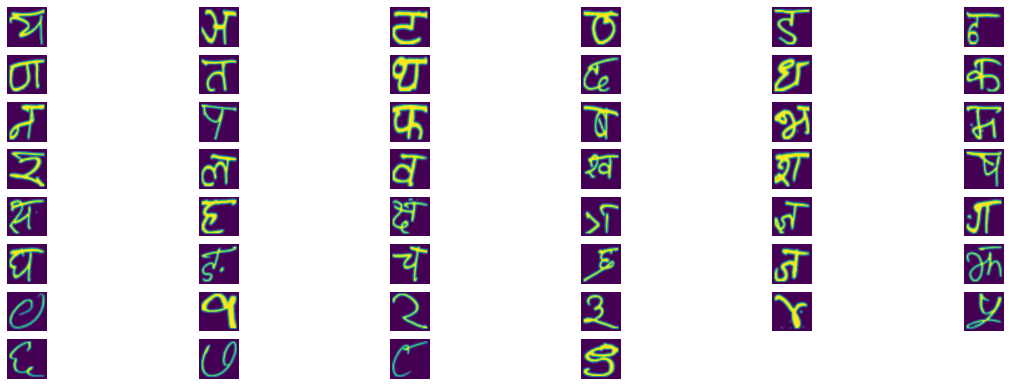

In [6]:
display_image(sample_imgs)


## Load Training and Test Dataset

In [7]:
print("Loading training data....")
train_data_img, train_data_labels = read_data_from_folder(train_path)
print("Loading test data....")
test_data_imgs, test_data_labels = read_data_from_folder(test_path)


Loading training data....


100%|██████████| 46/46 [00:11<00:00,  4.15it/s]


Loading test data....


100%|██████████| 46/46 [00:01<00:00, 26.13it/s]


## Display Dataset shapes

In [8]:
print("Training data imgs shape", train_data_img.shape)
print("Training data labels shape", train_data_labels.shape)
print("Test data imgs shape", test_data_imgs.shape)
print("Test data labels shape", test_data_labels.shape)


Training data imgs shape (78200, 32, 32, 1)
Training data labels shape (78200,)
Test data imgs shape (13800, 32, 32, 1)
Test data labels shape (13800,)


## Show some sample images from training dataset

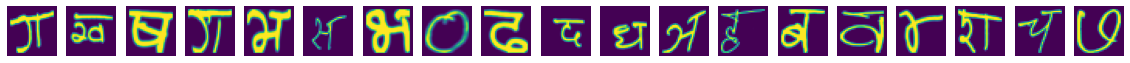

In [9]:
def display_image(imgarr):
    plt.figure(figsize=(20, 20))
    for i in range(len(imgarr)):
        plt.subplot(1, len(imgarr), i+1)
        plt.imshow(imgarr[i])
        plt.axis('off')
    plt.show()


rand = [random.randrange(1, 78200) for i in range(1, 20)]
display_image(train_data_img[rand])


## Add some augmented images in training set

In [10]:

def augment_data(images, labels):
    imgs = []
    labs = []
    data_gen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        brightness_range=(0.3, 1.0),
        fill_mode="nearest",
    )
    
    # generate samples and plot
    for i in range(images.shape[0]):
        # generate batch of images
        it = data_gen.flow(images[i:i+1], batch_size=1)
        batch = it.next()
        # convert to unsigned integers for viewing
        image = batch[0].astype("uint8")
        imgs.append(image)
        labs.append(labels[i])

    return imgs, labs

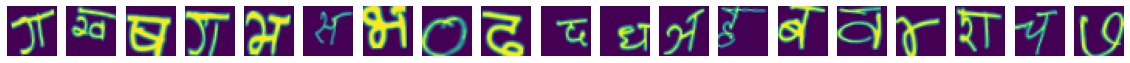

In [11]:
imgs, labels = augment_data(train_data_img[rand], train_data_labels[rand])
display_image(imgs)


In [12]:
imgs, labels = augment_data(train_data_img, train_data_labels)
train_data_img = np.concatenate((train_data_img, imgs))
train_data_labels = np.concatenate((train_data_labels, labels))

In [13]:
print("Training dataset shape after augmentation:", train_data_img.shape)
print("Training dataset labels shape after augmentation:", train_data_labels.shape)

Training dataset shape after augmentation: (156400, 32, 32, 1)
Training dataset labels shape after augmentation: (156400,)


In [14]:
TRAIN_LENGTH = train_data_img.shape[0]

## Define vocabulary for labels to convert label strings to int 

In [15]:
vocab = np.unique(train_data_labels)

label_to_int = tf.keras.layers.StringLookup(vocabulary=vocab, invert=False)
train_data_labels = label_to_int(train_data_labels)
test_data_labels = label_to_int(test_data_labels)


## Load datasets into TensorSliceDataset

In [16]:
train_images_ds = tf.data.Dataset.from_tensor_slices(
    (train_data_img, train_data_labels))

test_val_images_ds = tf.data.Dataset.from_tensor_slices(
    (test_data_imgs, test_data_labels))

#val_images_ds = tf.data.Dataset.from_tensor_slices((val_images, val_masks))


## Split Test dataset into Test and validation datasets

In [17]:
ds_size = 13800
ds = test_val_images_ds.shuffle(10000, seed=12)

test_size = int(0.5 * ds_size)
val_size = int(0.5 * ds_size)

test_images_ds = ds.take(test_size)
val_images_ds = ds.skip(test_size).take(val_size)


## Define Batch size

In [18]:
BUFFER_SIZE = TRAIN_LENGTH
BATCH_SIZE = 32
input_shape = (32, 32)


## Create Batches for all 3 dataset

In [19]:
train_batches = (
    train_images_ds
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    # .map(Augment())
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE))
# tf.data.AUTOTUNE

test_batches = test_images_ds.batch(BATCH_SIZE)
val_batches = val_images_ds.batch(BATCH_SIZE)


## Define CNN Model

In [20]:
OUTPUT_CLASSES = 47

model = tf.keras.models.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(32, 32, 1)),
    tf.keras.layers.Conv2D(16, 2, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 4, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])


## Compile  model

In [21]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
                  from_logits=True),
              metrics=['accuracy'])


## Show compiled model

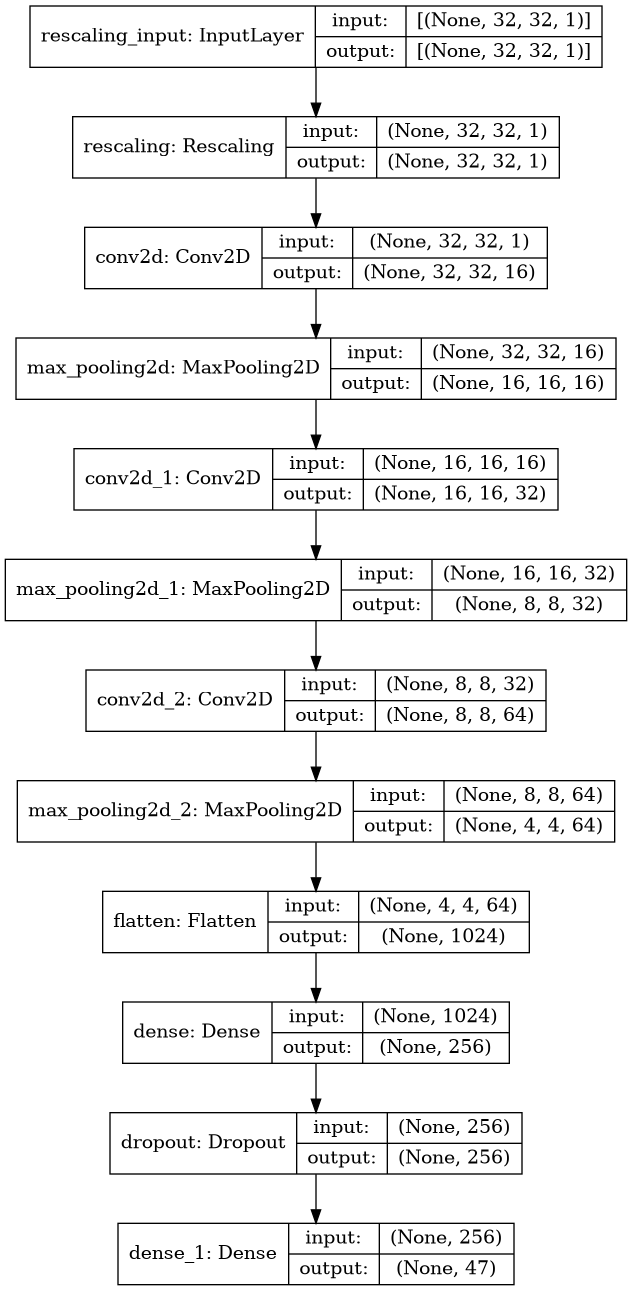

In [22]:
tf.keras.utils.plot_model(model, show_shapes=True)


## Callback functions for early stopping and Displaying information

In [23]:
int_to_label = tf.keras.layers.StringLookup(vocabulary=vocab, invert=True)


def show_images_predictions(imgs, pred):
    plt.figure(figsize=(15, 40))
    for i in range(len(imgs)):
        plt.subplot(32, 2, i+1)
        plt.imshow(imgs[i])
        lab = int_to_label([np.argmax(pred[i])]).numpy()[0]
        conf = np.max(tf.nn.softmax(pred[i])) * 100
        plt.title("Label:{} with confidence:{:.2f}%".format(lab, conf))
        plt.axis('off')
    plt.show()


def show_predictions(dataset=None, num=1, rec=BATCH_SIZE):

    for image_batch, label_batch in dataset.take(num):
        pred_batch = model.predict(image_batch[:rec])
        show_images_predictions(image_batch[:rec], pred_batch)
        # print(np.argmax(pred_batch[0]))


In [24]:
earlyStopCallback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, min_delta=0.0001, restore_best_weights=True)


for image_batch, label_batch in val_batches.take(1):
    sample_images = image_batch[:2]


class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # clear_output(wait=True)
        print('\nSample Prediction after epoch {}\n'.format(epoch+1))
        pred_batch = model.predict(sample_images)
        show_images_predictions(sample_images, pred_batch)
        # for key in logs.keys():
        #    print("epoch {}, the {} is {:7.2f}.".format(
        #     (epoch+1), key, logs[key]))
        # print(logs.keys())


## Train the model

Epoch 1/30


2021-11-02 20:55:10.109853: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-02 20:55:10.579195: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8204


4887/4887 [==============================] - 14s 3ms/step - loss: 0.6688 - accuracy: 0.8071 - val_loss: 0.1024 - val_accuracy: 0.9622

Sample Prediction after epoch 1



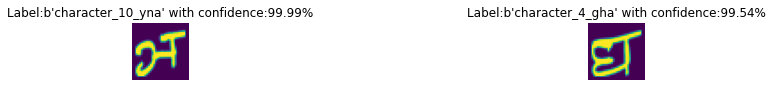

Epoch 2/30
4887/4887 [==============================] - 12s 2ms/step - loss: 0.2274 - accuracy: 0.9295 - val_loss: 0.0719 - val_accuracy: 0.9775

Sample Prediction after epoch 2



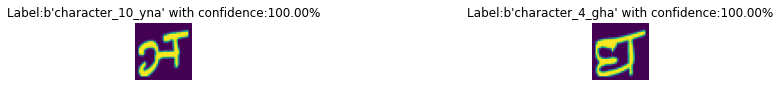

Epoch 3/30
4887/4887 [==============================] - 12s 2ms/step - loss: 0.1635 - accuracy: 0.9496 - val_loss: 0.0509 - val_accuracy: 0.9847

Sample Prediction after epoch 3



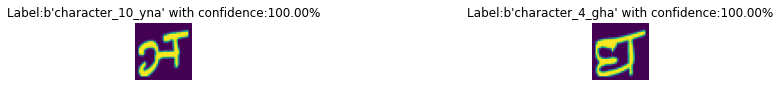

Epoch 4/30
4887/4887 [==============================] - 12s 2ms/step - loss: 0.1288 - accuracy: 0.9603 - val_loss: 0.0586 - val_accuracy: 0.9840

Sample Prediction after epoch 4



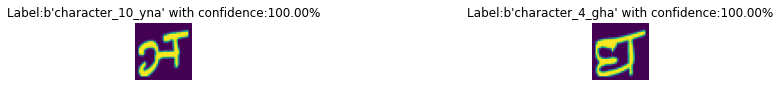

Epoch 5/30
4887/4887 [==============================] - 12s 2ms/step - loss: 0.1091 - accuracy: 0.9657 - val_loss: 0.0492 - val_accuracy: 0.9855

Sample Prediction after epoch 5



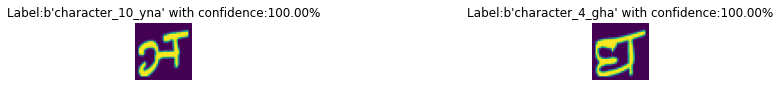

Epoch 6/30
4887/4887 [==============================] - 12s 2ms/step - loss: 0.0928 - accuracy: 0.9715 - val_loss: 0.0587 - val_accuracy: 0.9847

Sample Prediction after epoch 6



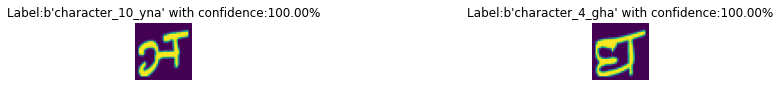

Epoch 7/30
4887/4887 [==============================] - 12s 2ms/step - loss: 0.0813 - accuracy: 0.9747 - val_loss: 0.0562 - val_accuracy: 0.9869

Sample Prediction after epoch 7



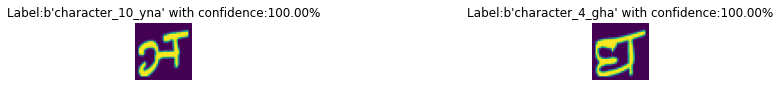

Epoch 8/30
4887/4887 [==============================] - 12s 2ms/step - loss: 0.0750 - accuracy: 0.9762 - val_loss: 0.0670 - val_accuracy: 0.9869

Sample Prediction after epoch 8



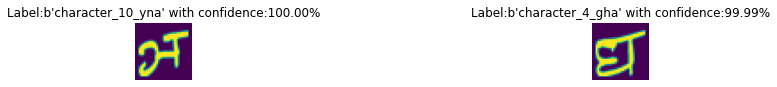

Epoch 9/30
4887/4887 [==============================] - 12s 2ms/step - loss: 0.0691 - accuracy: 0.9779 - val_loss: 0.0480 - val_accuracy: 0.9862

Sample Prediction after epoch 9



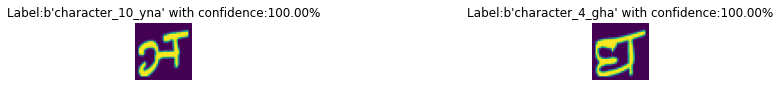

Epoch 10/30
4887/4887 [==============================] - 12s 2ms/step - loss: 0.0637 - accuracy: 0.9801 - val_loss: 0.0974 - val_accuracy: 0.9869

Sample Prediction after epoch 10



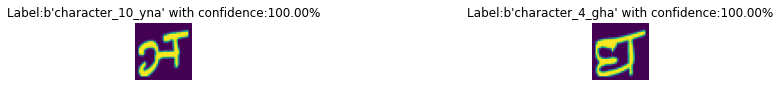

Epoch 11/30
4887/4887 [==============================] - 12s 2ms/step - loss: 0.0608 - accuracy: 0.9813 - val_loss: 0.0601 - val_accuracy: 0.9876

Sample Prediction after epoch 11



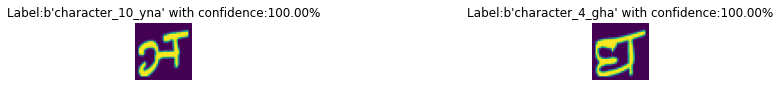

Epoch 12/30
4887/4887 [==============================] - 12s 2ms/step - loss: 0.0570 - accuracy: 0.9823 - val_loss: 0.0345 - val_accuracy: 0.9920

Sample Prediction after epoch 12



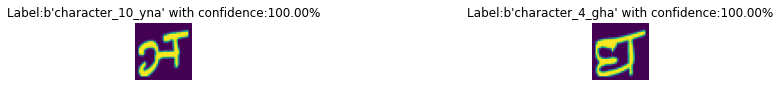

Epoch 13/30
4887/4887 [==============================] - 12s 2ms/step - loss: 0.0541 - accuracy: 0.9830 - val_loss: 0.0547 - val_accuracy: 0.9869

Sample Prediction after epoch 13



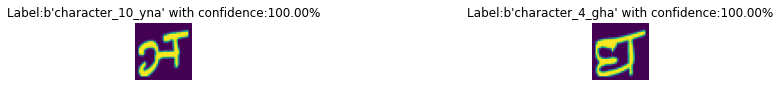

Epoch 14/30
4887/4887 [==============================] - 12s 2ms/step - loss: 0.0522 - accuracy: 0.9839 - val_loss: 0.0657 - val_accuracy: 0.9876

Sample Prediction after epoch 14



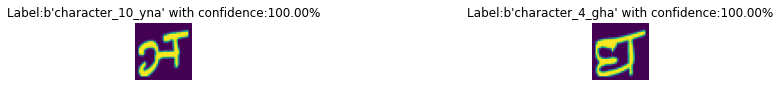

Epoch 15/30
4887/4887 [==============================] - 12s 2ms/step - loss: 0.0511 - accuracy: 0.9844 - val_loss: 0.0773 - val_accuracy: 0.9869

Sample Prediction after epoch 15



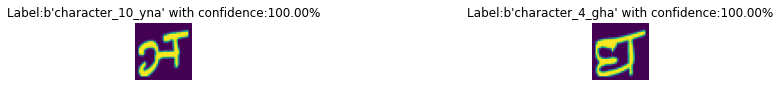

Epoch 16/30
4887/4887 [==============================] - 12s 2ms/step - loss: 0.0481 - accuracy: 0.9850 - val_loss: 0.0209 - val_accuracy: 0.9949

Sample Prediction after epoch 16



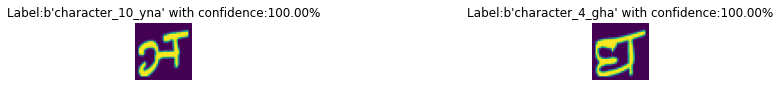

Epoch 17/30
4887/4887 [==============================] - 12s 2ms/step - loss: 0.0468 - accuracy: 0.9855 - val_loss: 0.0878 - val_accuracy: 0.9876

Sample Prediction after epoch 17



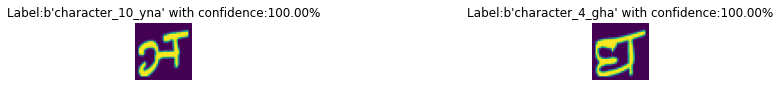

Epoch 18/30
4887/4887 [==============================] - 12s 2ms/step - loss: 0.0443 - accuracy: 0.9863 - val_loss: 0.0603 - val_accuracy: 0.9869

Sample Prediction after epoch 18



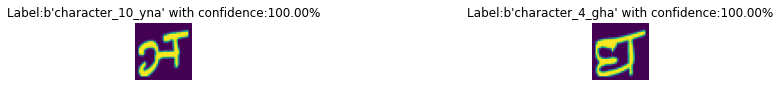

Epoch 19/30
4887/4887 [==============================] - 12s 3ms/step - loss: 0.0449 - accuracy: 0.9864 - val_loss: 0.0574 - val_accuracy: 0.9913

Sample Prediction after epoch 19



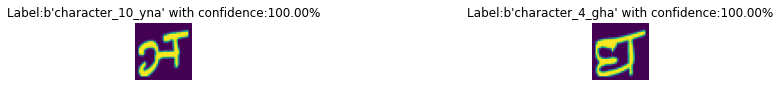

Epoch 20/30
4887/4887 [==============================] - 12s 2ms/step - loss: 0.0429 - accuracy: 0.9867 - val_loss: 0.0646 - val_accuracy: 0.9891

Sample Prediction after epoch 20



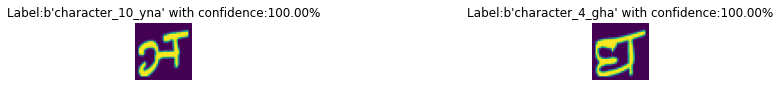

Epoch 21/30
4887/4887 [==============================] - 12s 2ms/step - loss: 0.0416 - accuracy: 0.9876 - val_loss: 0.0369 - val_accuracy: 0.9927

Sample Prediction after epoch 21



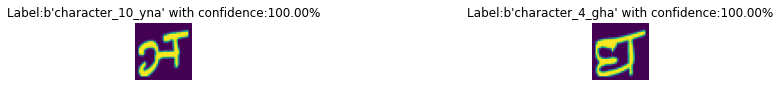

In [25]:
EPOCHS = 30
VAL_SUBSPLITS = 5
VAL_LENGTH = 6900
VALIDATION_STEPS = VAL_LENGTH//BATCH_SIZE//VAL_SUBSPLITS  # 10
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=val_batches,
                          callbacks=[DisplayCallback(), earlyStopCallback])
#


## Plot accuracy and loss for training and validations

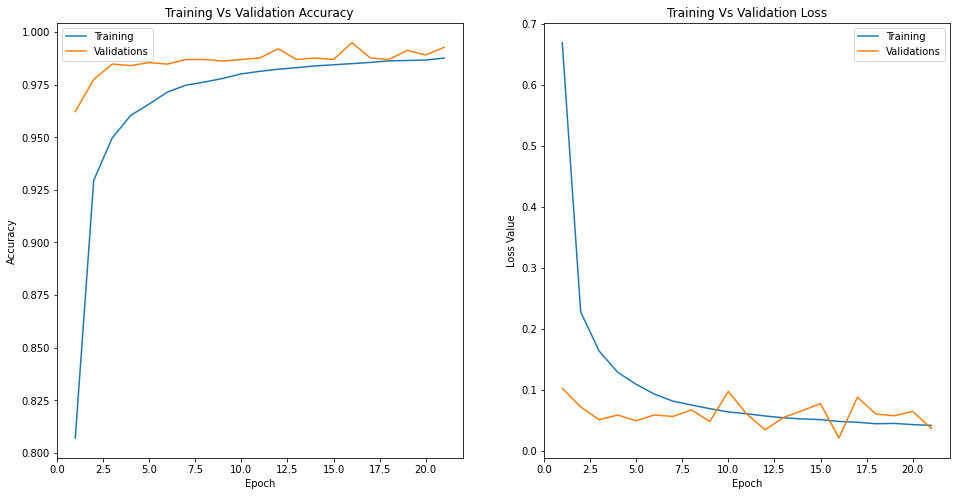

In [26]:
length = len(model_history.history["accuracy"])+1

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
titles = ['Training Vs Validation Accuracy', 'Training Vs Validation Loss']
ax[0].set_title(titles[0])
ax[0].plot(range(1, length), model_history.history["accuracy"])
ax[0].plot(range(1, length), model_history.history["val_accuracy"])
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(["Training", "Validations"])


ax[1].set_title(titles[1])
ax[1].plot(range(1, length), model_history.history["loss"])
ax[1].plot(range(1, length), model_history.history["val_loss"])
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss Value')
ax[1].legend(["Training", "Validations"])
plt.show()


## Evalute model against test dataset

In [27]:
model.evaluate(test_batches)


216/216 [==============================] - 0s 1ms/step - loss: 0.0762 - accuracy: 0.9883


[0.07615387439727783, 0.9882608652114868]

## Sample predictions from validation dataset

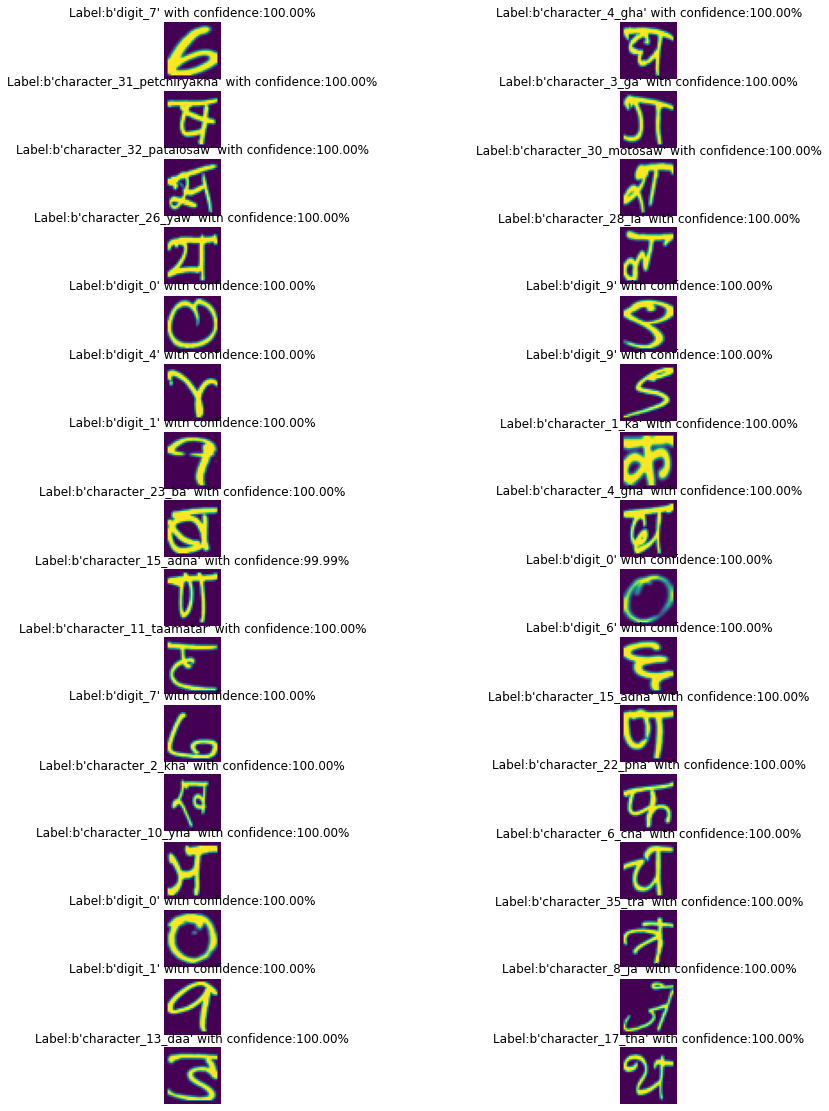

In [28]:
show_predictions(val_batches.shuffle(buffer_size=64), num=1)


## Sample Predictions from Test dataset

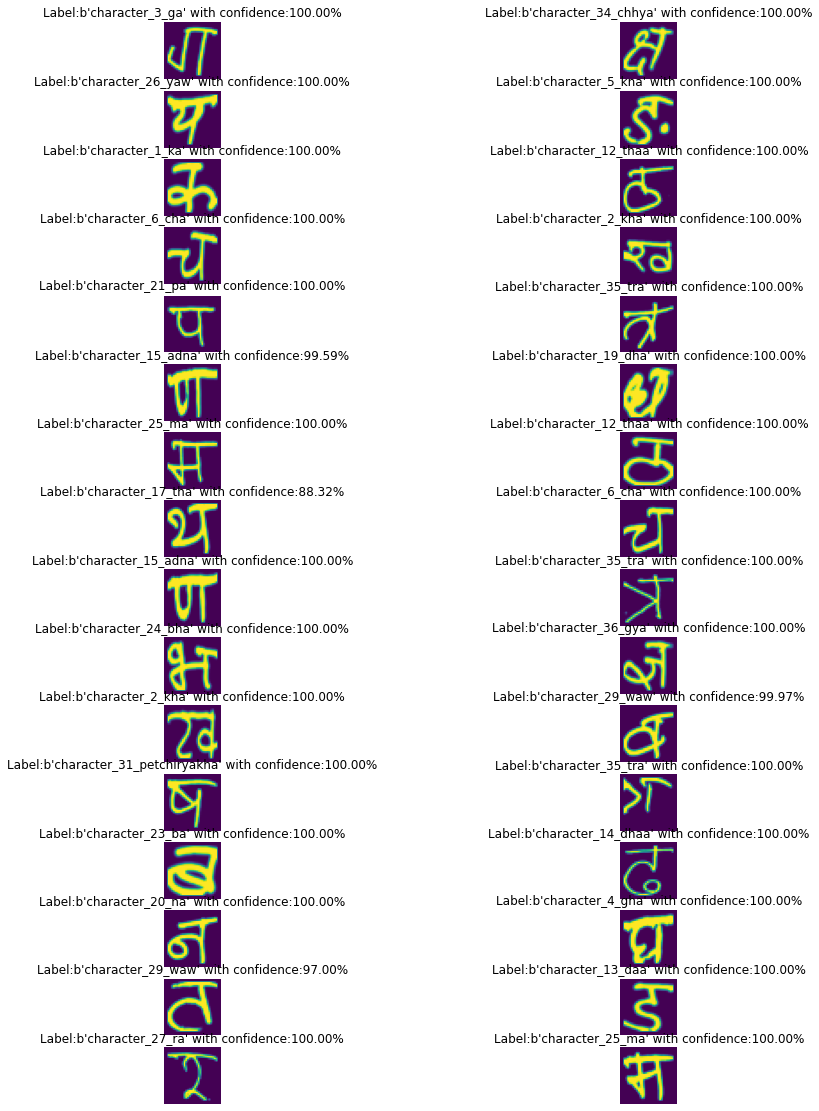

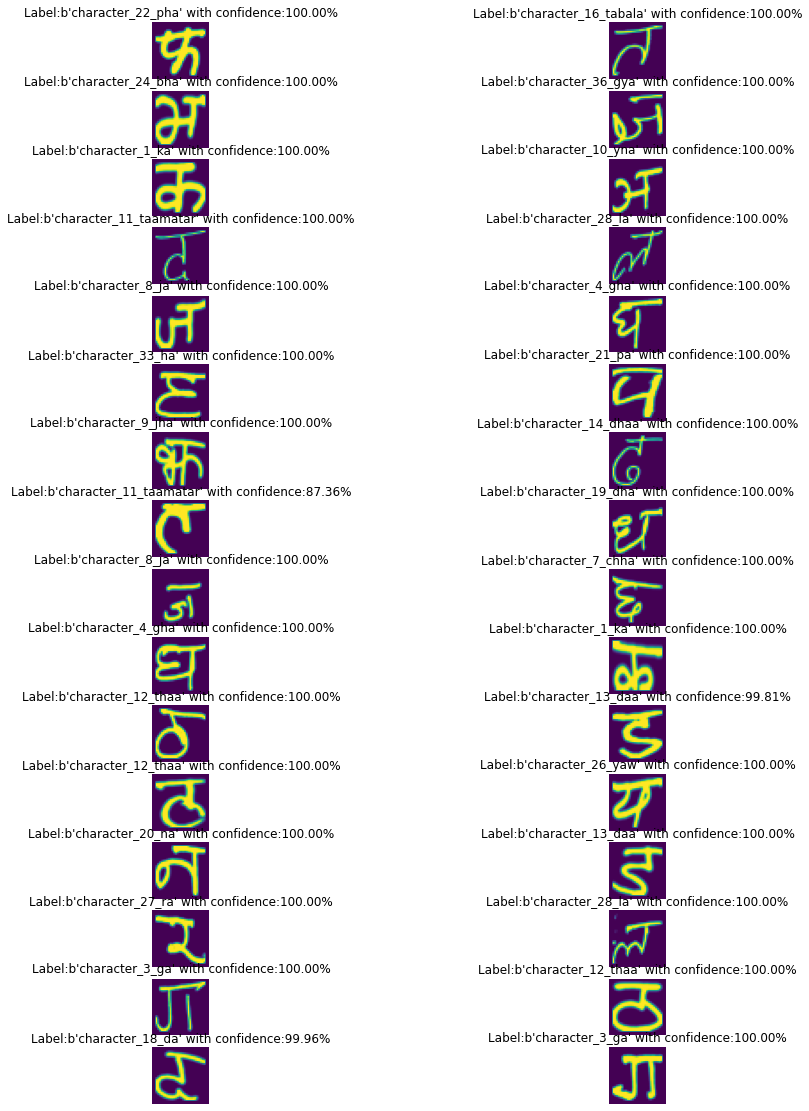

In [29]:
show_predictions(test_batches.shuffle(buffer_size=64), num=2)
